In [28]:
## Q2.
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl

In [29]:
pokemon_index_dict = {
    "Bug":0,
    "Dark":1,
    "Dragon":2,
    "Electric":3,
    "Fairy":4,
    "Fighting":5,
    "Fire":6,
    "Flying":7,
    "Ghost":8,
    "Grass":9,
    "Ground":10,
    "Ice":11,
    "Normal":12,
    "Poison":13,
    "Psychic":14,
    "Rock":15,
    "Steel":16,
    "Water":17
}

In [30]:
pokemon_type_list = [
    "Bug",
    "Dark",
    "Dragon",
    "Electric",
    "Fairy",
    "Fighting",
    "Fire",
    "Flying",
    "Ghost",
    "Grass",
    "Ground",
    "Ice",
    "Normal",
    "Poison",
    "Psychic",
    "Rock",
    "Steel",
    "Water"
]

In [31]:
# User input for image resolution
px = 128 
img_size = (px,px)

#Batch Size
batch_size = 25

#CPU to run on
current_device='cuda:5'

In [32]:
# Set the path to the dataset directories
image_directory = 'archive/images'  # Replace with the actual path to your dataset
path_to_type_csv = 'archive/pokemon.csv'

In [ ]:
class PokemonSingleTypeDataset(Dataset):
    """pokemon single type dataset."""

    def __init__(self, type_csv, root_dir, transform=None):
        """
        Arguments:
            types (string): Path to the csv file with type information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.type_list = pd.read_csv(type_csv)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.type_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.type_list.iloc[idx, 0] + ".png")

        # Load image as PIL and ensure RGB
        image = Image.open(img_name).convert('RGB')

        # Read label from CSV
        current_type = self.type_list.iloc[idx, 1]

        # Map string labels to integers if mapping exists in the notebook
        try:
            if isinstance(current_type, str):
                current_type = pokemon_index_dict.get(current_type, current_type)
        except NameError:
            # Mapping not defined yet in the notebook; leave as-is
            pass

        # Apply transforms (transforms expect a PIL Image)
        if self.transform:
            image = self.transform(image)
        else:
            # Fallback: convert PIL image to float tensor in [0,1]
            image = transforms.functional.pil_to_tensor(image).float() / 255.0

        label = int(current_type)

        return image, label

In [34]:
# Visualize data 

# Define function that plots multiple images in an array of images
def PlotImages(ix_start,num_img,rows,cols,images,labels,color=True):
    plt.figure(figsize=(10,10))
    plt.subplots_adjust(wspace=0.5,hspace=0.5)
    for i in range(num_img):
        plt.subplot(rows,cols,i+1)
        plt.axis('off')
        if color:
            plt.imshow(images.permute(0, 2, 3, 1)[ix_start+i])
        else: 
            plt.imshow(np.squeeze(images[ix_start+i]),cmap='Greys')
        plt.title(pokemon_type_list[labels[ix_start+i].item()])

# Image loader and scaler for image exploration
explorer_batch_size = 25
load_image = transforms.Compose([
    transforms.Resize((px, px)),
    transforms.ToTensor()
])
dataset = PokemonSingleTypeDataset(path_to_type_csv, image_directory)
dataloader = DataLoader(dataset, batch_size=explorer_batch_size, shuffle=True)
data_iter = iter(dataloader)

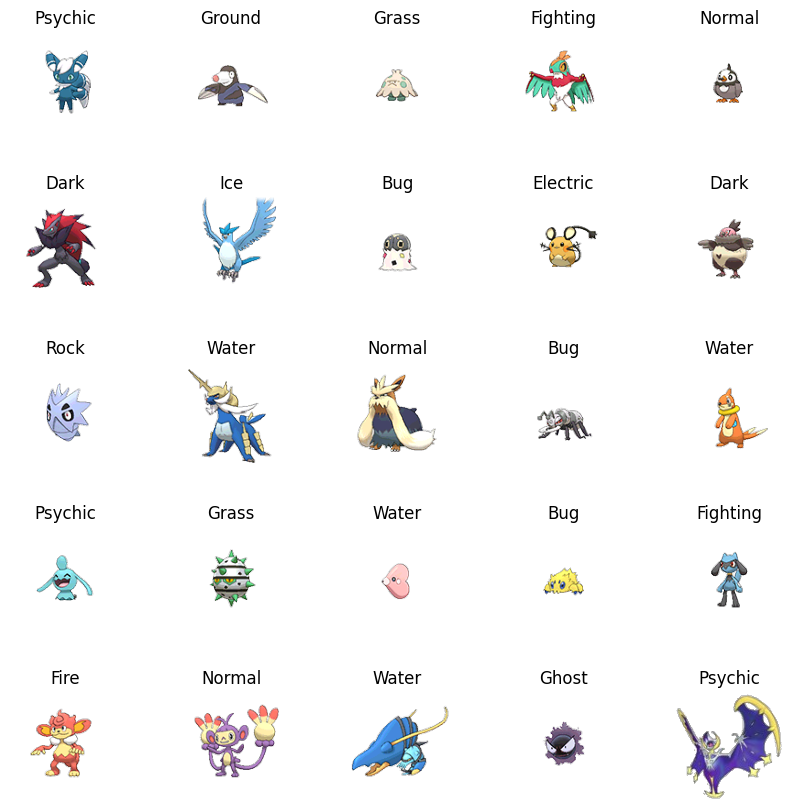

In [35]:
images, labels = next(data_iter)
next(data_iter)
PlotImages(0,explorer_batch_size,5,5,images,labels,color=True)

In [36]:
# Define a function to extract features using VGG16
# Runs on GPU 0 by default.
def extract_features(data_dir, img_size, batch_size=32, device='cuda:7'):
    """
    Extract features from images using the convolutional layers of the VGG16 network.
    
    Args:
        data_dir (str): Directory containing the image dataset. Each class should have its own subfolder.
        img_size (tuple): The resolution (width, height) of the images to resize.
        batch_size (int): Number of images to process in one batch.
        device (str): The device to run the model on, 'cuda' or 'cpu'.
        
    Returns:
        features (numpy.ndarray): Extracted features from the images.
        labels (list): Corresponding class labels for each extracted feature.
    """

    # Load the pre-trained VGG16 model
    vgg16 = models.vgg16(weights='VGG16_Weights.DEFAULT')

    # Only use the convolutional layers (remove the fully connected layers)
    # VGG16 features have conv layers + pooling
    vgg16_features = nn.Sequential(*list(vgg16.features.children())).to(device)

    # Disable gradient calculations since we're only using the model for feature extraction
    for param in vgg16_features.parameters():
        param.requires_grad = False

    # Define the image transformation pipeline
    transform = transforms.Compose([
        transforms.Resize(img_size),      # Resize to the specified resolution
        transforms.ToTensor(),            # Convert images to PyTorch tensors
        transforms.Normalize(             # Normalize images to match VGG16 input requirements
            mean=[0.485, 0.456, 0.406],   # These are the mean values for VGG16's training data (ImageNet)
            std=[0.229, 0.224, 0.225]     # These are the standard deviations for ImageNet
        )
    ])

    # Load the dataset, where each class is in its own subfolder
    dataset = PokemonSingleTypeDataset(data_dir, image_directory, transform=transform)

    # Create a DataLoader to handle batch processing of images
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Lists to store extracted features and corresponding labels
    all_features = []
    all_labels = []

    # Iterate through the dataset in batches
    for images, labels in dataloader:
        images = images.to(device)  # Send images to the specified device (GPU or CPU)

        # Pass images through the VGG16 convolutional layers
        features = vgg16_features(images)

        # Flatten the features (we take the output from the last conv layer)
        features = features.view(features.size(0), -1)

        # Move the features back to CPU (to prepare for saving)
        features = features.cpu().detach().numpy()

        # Append the extracted features and labels
        all_features.append(features)
        all_labels.append(labels.numpy())  # Labels are already on CPU, so just append them

    # Concatenate all features and labels from the batches into single arrays
    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    return all_features, all_labels

In [37]:
# Extract features and labels
# Runs on GPU 5.
features, labels = extract_features(path_to_type_csv, img_size, batch_size=explorer_batch_size, device=current_device)

# Save the extracted features and labels as a .npz file
np.savez('pokemon_features_with_labels.npz', features=features, labels=labels)

print(f"Features and labels extracted and saved to 'pokemon_features_with_labels.npz'.")

RuntimeError: The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 0

In [ ]:
# Impot necessary libraries
from time import time  # For measuring performance time
from sklearn.model_selection import train_test_split  # For splitting data into train and test sets.

In [ ]:
features = np.load('pokemon_features_with_labels.npz')['features']
labels   = np.load('pokemon_features_with_labels.npz')['labels']

In [ ]:
X, X_test, y, y_test = train_test_split(features, labels, test_size=0.2, random_state=0)
print('X',X.shape,'y',y.shape)
print('X_test',X_test.shape,'y_test',y_test.shape)

X (647, 8192) y (647,)
X_test (162, 8192) y_test (162,)


In [ ]:
# This class encapsulates all the data loading and preparation steps.
# It helps keep data-related code organized and separate from the model code.
class PokemonDataModule(pl.LightningDataModule):
    def __init__(self, X_train, y_train, X_test, y_test, batch_size=64):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.batch_size = batch_size

    # The setup stage is called on every GPU in distributed training
    def setup(self, stage=None):
        # Create custom Dataset objects for training and testing
        self.train_dataset = PokemonDataset(self.X_train, self.y_train)
        self.test_dataset = PokemonDataset(self.X_test, self.y_test)

    # Returns the DataLoader for the training set
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    # Returns the DataLoader for the test set
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

# Define the custom Dataset class used by the DataModule
# This class tells PyTorch how to get a single item (image and label) from the dataset.
class PokemonDataset(Dataset):
    def __init__(self, features, targets, transform=None):
        self.features = features
        self.targets = targets
        self.transform = transform

    def __len__(self):
        # Returns the total number of samples
        return len(self.features)

    def __getitem__(self, index):
        # Retrieves one sample at the given index
        image = self.features[index]
        label = self.targets[index]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [ ]:
# This class defines the model architecture, the training logic, and the optimizer.
# It abstracts away the training loop, making the code cleaner.
class LogisticRegressionLightning(pl.LightningModule):
    def __init__(self, input_size=8192, num_classes=len(pokemon_type_list), hidden_layer=8192, learning_rate=0.01): #TODO: replace input_size with dynamic number
        super().__init__()
        self.learning_rate = learning_rate
        self.linear = nn.Linear(input_size, hidden_layer)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_layer, num_classes)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        # Flatten the input image from 28x28 to a 784-element feature vector
        x = x.view(x.size(0), -1)
        # Pass the flattened image through the linear layer
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

    def training_step(self, batch, batch_idx):
        # This function is called for each batch of training data.
        images, labels = batch
        outputs = self(images)  # Forward pass
        loss = self.criterion(outputs, labels) # Calculate loss
        self.log('train_loss', loss) # Log the loss for monitoring
        return loss

    def test_step(self, batch, batch_idx):
        # This function is called for each batch of test data.
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / labels.size(0)
        
        # Log test loss and accuracy
        self.log('test_loss', loss)
        self.log('test_acc', accuracy)

    def configure_optimizers(self):
        # Defines the optimizer to be used for training
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

In [ ]:
# Instantiate the DataModule
# This organizes all data-related preparations.
pokemon_data = PokemonDataModule(X, y, X_test, y_test, batch_size=batch_size)

# Instantiate the Lightning model
model = LogisticRegressionLightning()

In [ ]:
# The Trainer handles the training, testing, and other engineering details.
# 'accelerator="auto"' will automatically use a GPU if available.
# run command 'nvidia-smi' in a terminal to see available GPUs
trainer = pl.Trainer(max_epochs=5, 
                     accelerator='gpu',
                     devices=[4])   
# devices tells it which GPU to run on. If many students are running this at the same time, you may need to change this; use a value from 0-7.

# Start the training process
time_start = time()
trainer.fit(model, pokemon_data)
time_stop = time()

print(f"Elapsed training time: {round(time_stop - time_start, 1)} sec.")

# Evaluate the model on the test dataset
trainer.test(model, datamodule=pokemon_data)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | linear    | Linear           | 67.1 M | train
1 | relu      | ReLU             | 0      | train
2 | linear2   | Linear           | 147 K  | train
3 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
67.3 M    Trainable params
0         Non-trainable params
67.3 M    Total params
269.058   Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
/work/envs/venv/DL_gpu/lib/python3.11/site-packages/pytorch_lightni

Epoch 4: 100%|██████████| 26/26 [00:00<00:00, 47.79it/s, v_num=17]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 26/26 [00:13<00:00,  1.88it/s, v_num=17]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/work/envs/venv/DL_gpu/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


Elapsed training time: 68.8 sec.
Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 33.15it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.1358024626970291
        test_loss            3.857560873031616
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 3.857560873031616, 'test_acc': 0.1358024626970291}]